In [1]:
import tensorflow as tf
#Lets first create functions to preprocess our data
def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, TARGET_SHAPE[:2])
    return image


def preprocess_triplets(anchor, positive, negative):
    """
    Given the filenames corresponding to the three images,
    preprocess them.
    """
    return preprocess_image(anchor), preprocess_image(positive), preprocess_image(negative)

In [2]:
#Lets also write function so that we can vizualize our train and val data
import matplotlib.pyplot as plt
def visualize(anchor, positive, negative, n=3):
    """Visualize triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(3*n, 9))

    axs = fig.subplots(n, 3)
    for i in range(n):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])

In [3]:
import pandas as pd
import tensorflow as tf

#Lets define batch size and target shape of our images
BATCH_SIZE = 4
TARGET_SHAPE = (224, 224, 3)




def load_and_process_data(file_path):
    dataframe = pd.read_csv(file_path)
    for column in dataframe.columns:
        dataframe[column] = dataframe[column].apply(lambda x: x.replace("\\", "/"))
    
    anchor_images = dataframe.anchor.to_list()
    positive_images = dataframe.positive.to_list()
    negative_images = dataframe.negative.to_list()
    image_count = len(anchor_images)
    
    anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
    positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)
    negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
    
    dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
    dataset = dataset.shuffle(buffer_size=1024)
    dataset = dataset.map(preprocess_triplets)
    
    train_dataset = dataset.take(round(image_count * 0.8))
    val_dataset = dataset.skip(round(image_count * 0.8))
    
    train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=False)
    train_dataset = train_dataset.prefetch(8)
    
    val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=False)
    val_dataset = val_dataset.prefetch(8)
    
    return train_dataset, val_dataset

In [4]:
#Now lets load the eyewear data
handbags_train, handbags_val = load_and_process_data("./handbags_pairs.csv")

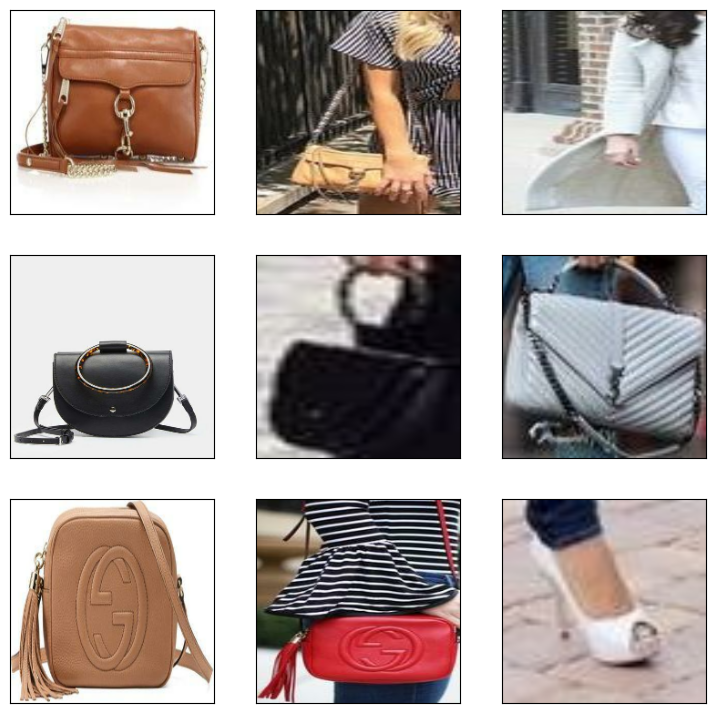

In [5]:
#Now lets vizualize our data
visualize(*list(handbags_train.take(1).as_numpy_iterator())[0])

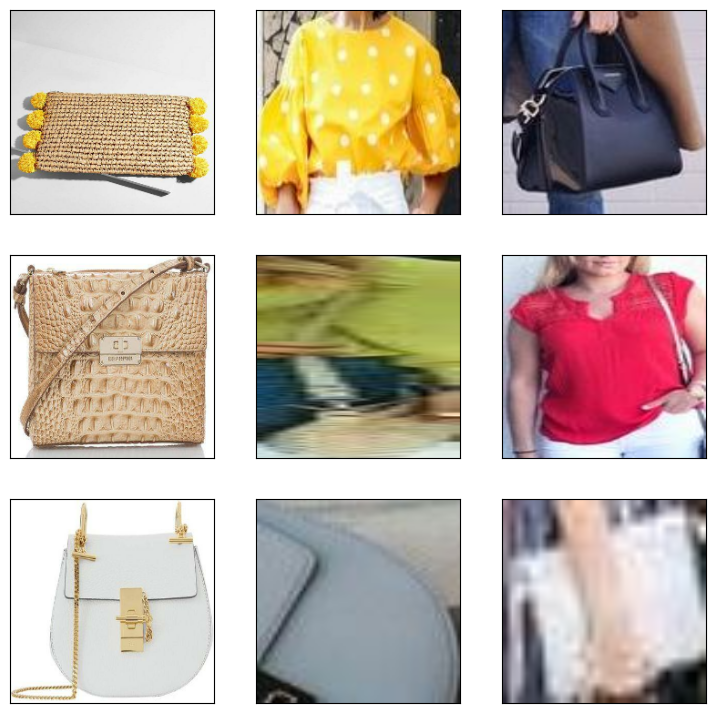

In [6]:
#Now lets vizualize our val data
visualize(*list(handbags_val.take(1).as_numpy_iterator())[0])

In [7]:
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout, Input
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

In [8]:
from tensorflow.keras.applications import InceptionV3
from keras.regularizers import l2

In [9]:
# Define the size of the embedding vector we want in the output
EMBEDDING_DIMENSION = 256

# Load InceptionV3 as the base model, excluding the top layer
inception_base_model = InceptionV3(weights="imagenet", input_shape=TARGET_SHAPE, include_top=False)


# Unfreeze the all layers for fine-tuning
for layer in inception_base_model.layers:  # Unfreeze the last 20 layers
    layer.trainable = True


# Add custom layers on top of the base model
x = Flatten()(inception_base_model.output)

# Add a dense layer with  ReLU activation
x = Dense(512,activation="relu")(x)
x=Dropout(0.4)(x)
x=Dense(256,activation="relu")(x)
x=Dropout(0.4)(x)

# Add the final output layer with linear activation for the embedding
output = Dense(EMBEDDING_DIMENSION, activation="linear")(x)

# Define the complete embedding model
embedding = Model(inception_base_model.input, output, name="Embedding")



In [10]:
class DistanceLayer(tf.keras.layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

anchor_input = Input(name="anchor", shape=TARGET_SHAPE)
positive_input = Input(name="positive", shape=TARGET_SHAPE)
negative_input = Input(name="negative", shape=TARGET_SHAPE)

# Compute the distances
distances = DistanceLayer()(
    embedding(anchor_input),
    embedding(positive_input),
    embedding(negative_input)
)

# Define the final siamese network
siamese_network = Model(inputs=[anchor_input, positive_input, negative_input], outputs=distances)

In [11]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        ap_distance, an_distance = self.siamese_network(data)
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        return [self.loss_tracker]

In [13]:
callbacks = [EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True)]

siamese_model = SiameseModel(siamese_network)
# Compile the model with RMSprop optimizer
siamese_model.compile(optimizer=optimizers.Adam(0.00001), weighted_metrics=[])

history = siamese_model.fit(handbags_train, epochs=150, validation_data=handbags_val, callbacks=callbacks)

Epoch 1/150
1263/1263 [==============================] - 205s 153ms/step - loss: 1.7640 - val_loss: 0.3923
Epoch 2/150
1263/1263 [==============================] - 209s 166ms/step - loss: 0.4387 - val_loss: 0.3249
Epoch 3/150
1263/1263 [==============================] - 211s 167ms/step - loss: 0.3550 - val_loss: 0.3487
Epoch 4/150
1263/1263 [==============================] - 201s 159ms/step - loss: 0.3158 - val_loss: 0.3177
Epoch 5/150
1263/1263 [==============================] - 174s 138ms/step - loss: 0.2729 - val_loss: 0.2754
Epoch 6/150
1263/1263 [==============================] - 175s 138ms/step - loss: 0.2318 - val_loss: 0.2708
Epoch 7/150
1263/1263 [==============================] - 174s 138ms/step - loss: 0.1970 - val_loss: 0.2263
Epoch 8/150
1263/1263 [==============================] - 174s 138ms/step - loss: 0.1585 - val_loss: 0.2183
Epoch 9/150
1263/1263 [==============================] - 174s 137ms/step - loss: 0.1314 - val_loss: 0.2274
Epoch 10/150
1263/1263 [=============

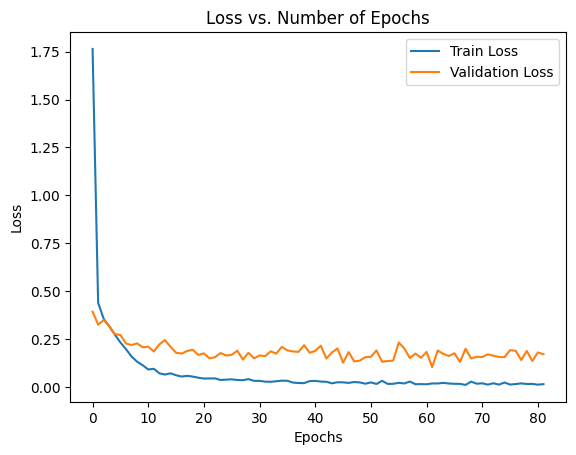

In [14]:
# Plot the training and validation loss over epochs
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Number of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
#Now lets see how good of embeddings our model is generating on val data
sample = next(iter(handbags_val))
anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (embedding(anchor), embedding(positive), embedding(negative))

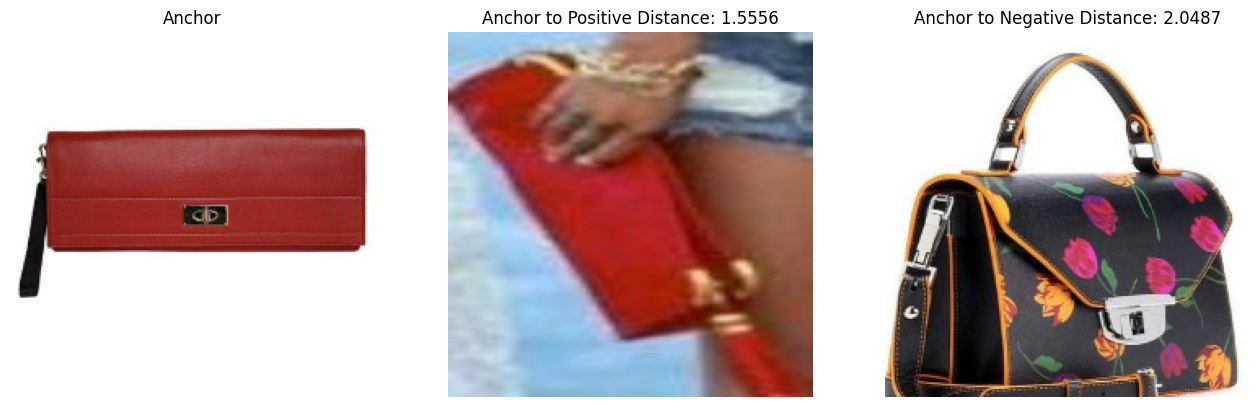

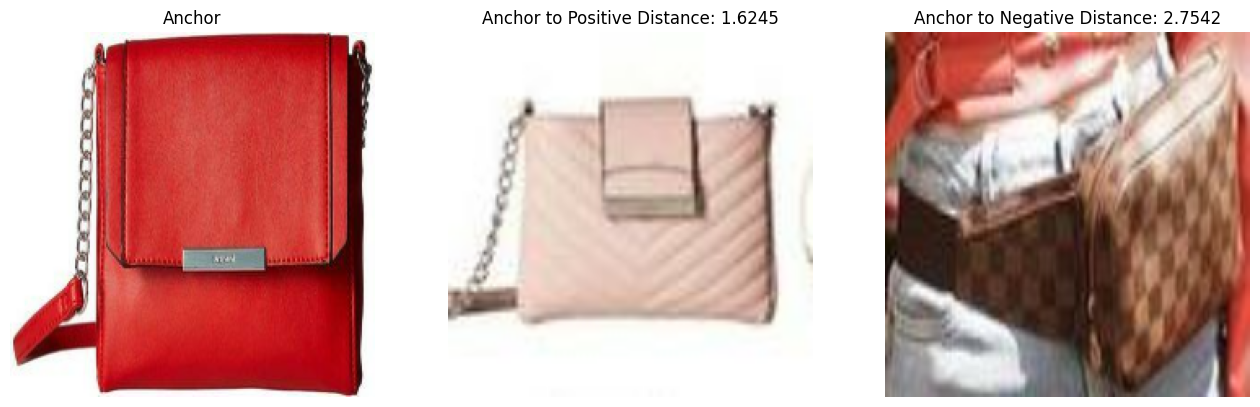

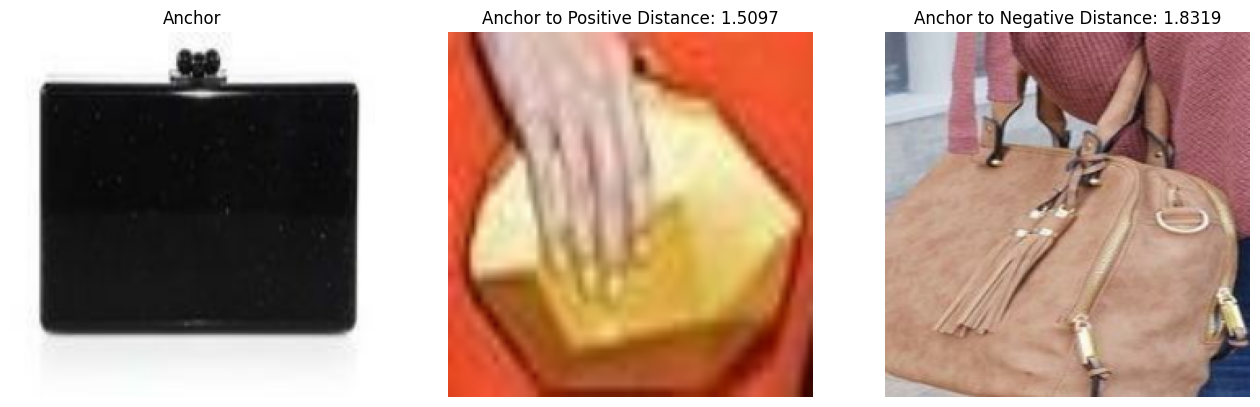

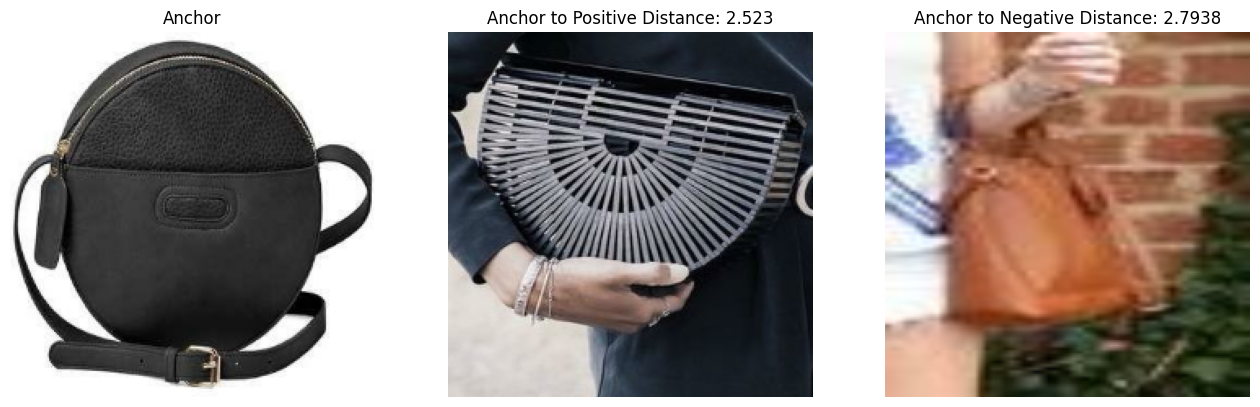

In [19]:
import numpy as np

anchors, positives, negatives = sample
for i in range(len(anchor_embedding)):
    anchor, positive, negative = anchors[i], positives[i], negatives[i]
    positive_distance = np.linalg.norm(anchor_embedding[i] - positive_embedding[i], ord=2)*1e4
    negative_distance = np.linalg.norm(anchor_embedding[i] - negative_embedding[i], ord=2)*1e4
    positive_distance, negative_distance = round(positive_distance)/1e4, round(negative_distance)/1e4
    plt.figure(figsize=(16,9))
    plt.subplot(131)
    plt.imshow(anchor)
    plt.axis("off")
    plt.title("Anchor")
    plt.subplot(132)
    plt.imshow(positive)
    plt.axis("off")
    plt.title(f"Anchor to Positive Distance: {positive_distance}")
    plt.subplot(133)
    plt.imshow(negative)
    plt.axis("off")
    plt.title(f"Anchor to Negative Distance: {negative_distance}")
    plt.show()        

In [20]:
#Now lets see how good of embeddings our model is generating on train data
sample = next(iter(handbags_train))
anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (embedding(anchor), embedding(positive), embedding(negative))

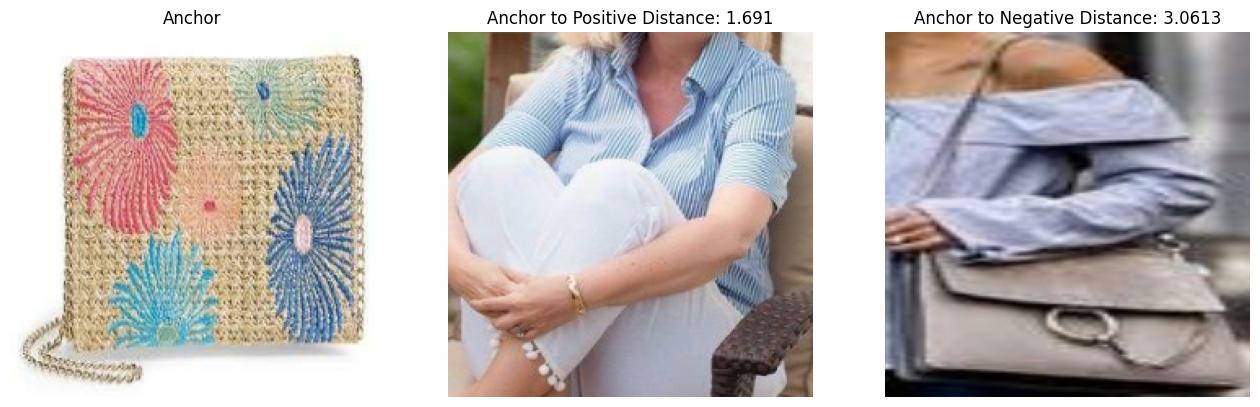

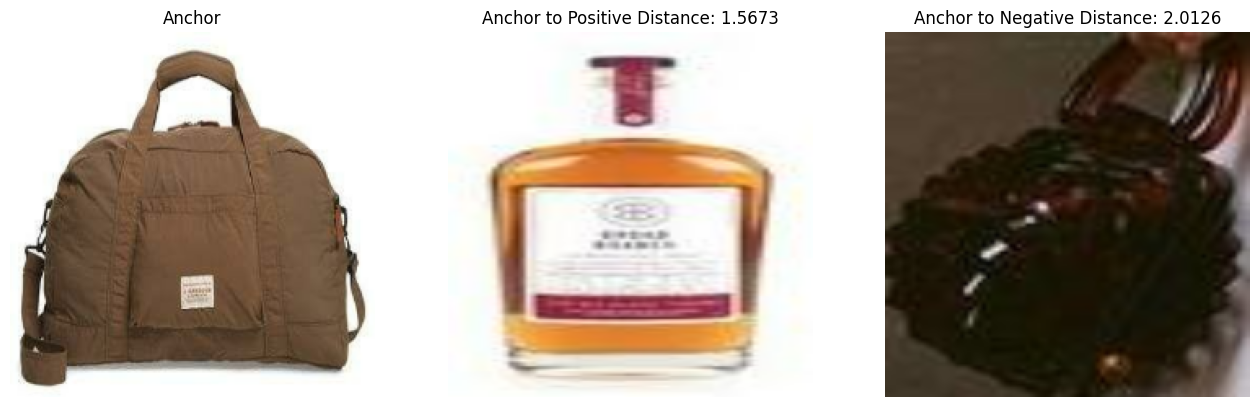

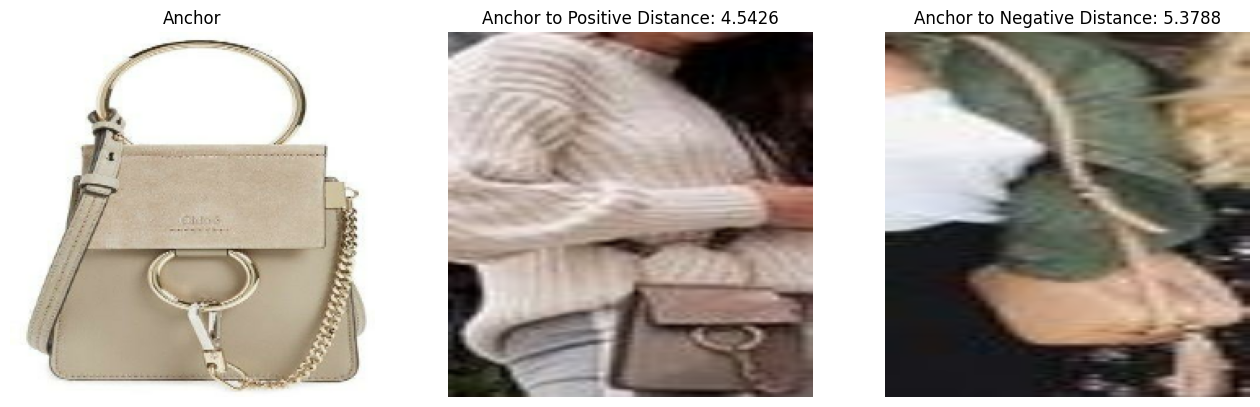

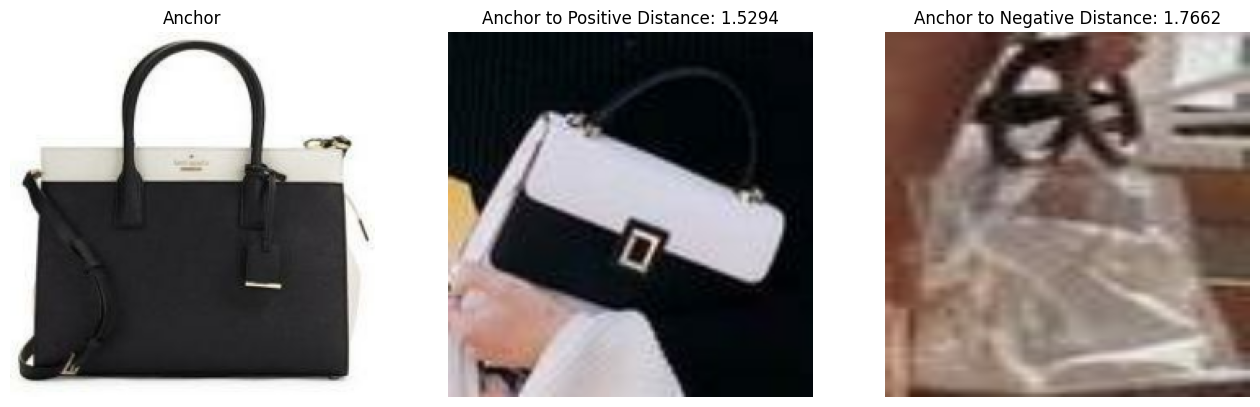

In [21]:
anchors, positives, negatives = sample
for i in range(len(anchor_embedding)):
    anchor, positive, negative = anchors[i], positives[i], negatives[i]
    positive_distance = np.linalg.norm(anchor_embedding[i] - positive_embedding[i], ord=2)*1e4
    negative_distance = np.linalg.norm(anchor_embedding[i] - negative_embedding[i], ord=2)*1e4
    positive_distance, negative_distance = round(positive_distance)/1e4, round(negative_distance)/1e4
    plt.figure(figsize=(16,9))
    plt.subplot(131)
    plt.imshow(anchor)
    plt.axis("off")
    plt.title("Anchor")
    plt.subplot(132)
    plt.imshow(positive)
    plt.axis("off")
    plt.title(f"Anchor to Positive Distance: {positive_distance}")
    plt.subplot(133)
    plt.imshow(negative)
    plt.axis("off")
    plt.title(f"Anchor to Negative Distance: {negative_distance}")
    plt.show()        

In [22]:
# Save the model in H5 format
embedding.save('./embedding generating models/embedding_handbags_InceptionV3.h5')